# Time Series Similarity Search with aeon

<img src="img/sim_search.png" width="600" alt="time series similarity search">

The `similarity_search` module in aeon provides estimators with a `fit`/`predict` interface for finding nearest neighbors in time series data. All estimators follow a standard interface:

- **fit(X)**: Takes a 3D collection of shape `(n_cases, n_channels, n_timepoints)`
- **predict(X)**: Takes a 2D query series of shape `(n_channels, n_timepoints)`

The module is organized by search type:

- `subsequence` estimators find nearest neighbors among subsequences of time series
- `whole_series` estimators find nearest neighbors among complete time series

### Other similarity search notebooks

This notebook gives an overview of similarity search module and the available estimators. The following notebooks are also available to go more in depth with specific subjects:

- [The theory and math behind the similarity search estimators in aeon](distance_profiles.ipynb)
- [Analysis of the performance of the estimators provided by similarity search module](code_speed.ipynb)

## 1. Setup and Data

First, let's import the estimators and load some example data. We'll create also define some functions to plot the results of each estimator.

In [ ]:
# Imports
from aeon.datasets import load_arrow_head
from aeon.similarity_search.subsequence import MASS
from aeon.similarity_search.subsequence import BruteForce as SubseqBruteForce
from aeon.similarity_search.whole_series import BruteForce as WholeBruteForce
from aeon.testing.data_generation import make_example_3d_numpy

# Create a sample collection: 4 cases, 1 channel, 50 timepoints each
X, _ = load_arrow_head()
print("Collection shape (fit input):", X.shape)

# Create a query series: 1 channel, 10 timepoints
q = X[0, :, :10]  # Extract a short query from first series
print("Query shape (predict input):", q.shape)

Collection shape (fit input): (80, 6, 100)
Query shape (predict input): (6, 10)


In [2]:
import matplotlib.pyplot as plt
import numpy as np


def plot_subsequence_search_results(
    X, query, matches, distances, title="Subsequence Search Results"
):
    """
    Plot the results of a subsequence similarity search.

    Parameters
    ----------
    X : np.ndarray, shape (n_cases, n_channels, n_timepoints)
        The fitted collection of time series.
    query : np.ndarray, shape (n_channels, query_length)
        The query subsequence.
    matches : np.ndarray, shape (n_matches, 2)
        Match indices as (case_idx, timestamp) pairs.
    distances : np.ndarray, shape (n_matches,)
        Distances to each match.
    title : str
        Title for the plot.
    """
    n_matches = len(matches)
    query_length = query.shape[1]

    fig, axes = plt.subplots(n_matches + 1, 1, figsize=(12, 2.5 * (n_matches + 1)))
    if n_matches == 0:
        return

    # Plot query
    axes[0].plot(query[0], "b-", linewidth=2, label="Query")
    axes[0].set_title(f"{title} - Query (length={query_length})")
    axes[0].set_xlabel("Time")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot each match
    colors = plt.cm.tab10(np.linspace(0, 1, n_matches))
    for i, ((case_idx, timestamp), dist) in enumerate(zip(matches, distances)):
        ax = axes[i + 1]
        series = X[case_idx, 0]

        # Plot full series in gray
        ax.plot(series, "gray", alpha=0.5, linewidth=1, label="Full series")

        # Highlight the matched subsequence
        match_end = timestamp + query_length
        ax.plot(
            range(timestamp, match_end),
            series[timestamp:match_end],
            color=colors[i],
            linewidth=2.5,
            label=f"Match (dist={dist:.4f})",
        )

        # Mark start and end points
        ax.axvline(x=timestamp, color=colors[i], linestyle="--", alpha=0.7)
        ax.axvline(x=match_end - 1, color=colors[i], linestyle="--", alpha=0.7)

        ax.set_title(f"Match {i+1}: Case {case_idx}, Timestamp {timestamp}")
        ax.set_xlabel("Time")
        ax.legend(loc="upper right")
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_whole_series_search_results(
    X, query, matches, distances, title="Whole Series Search Results"
):
    """
    Plot the results of a whole series similarity search.

    Parameters
    ----------
    X : np.ndarray, shape (n_cases, n_channels, n_timepoints)
        The fitted collection of time series.
    query : np.ndarray, shape (n_channels, n_timepoints)
        The query series.
    matches : np.ndarray, shape (n_matches,)
        Indices of matched cases.
    distances : np.ndarray, shape (n_matches,)
        Distances to each match.
    title : str
        Title for the plot.
    """
    n_matches = len(matches)

    fig, axes = plt.subplots(1, n_matches + 1, figsize=(4 * (n_matches + 1), 3))
    if n_matches == 0:
        return

    # Plot query
    axes[0].plot(query[0], "b-", linewidth=2)
    axes[0].set_title("Query")
    axes[0].set_xlabel("Time")
    axes[0].grid(True, alpha=0.3)

    # Plot each match
    colors = plt.cm.tab10(np.linspace(0, 1, n_matches))
    for i, (case_idx, dist) in enumerate(zip(matches, distances)):
        ax = axes[i + 1]
        ax.plot(X[case_idx, 0], color=colors[i], linewidth=2)
        ax.set_title(f"Match {i+1}: Case {case_idx}\nDist={dist:.4f}")
        ax.set_xlabel("Time")
        ax.grid(True, alpha=0.3)

    fig.suptitle(title, fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.show()

## 2. Subsequence Search

Subsequence search estimators find the closest matching subsequences within a collection of time series. The `predict` method returns a 2D array of shape `(n_matches, 2)` containing pairs of `(case_index, timestamp_index)` indicating where in the collection the best matches were found.

### 2.1 Brute force

The simplest method available is the brute force search. It computes the euclidean distance between the query and all subsequences of the input collection.

In [3]:
# Fit BruteForce subsequence search
subseq_brute = SubseqBruteForce(length=10, normalize=False)
subseq_brute.fit(X)  # Fit on 3D collection

# Predict with k=3 to find top 3 closest subsequences
# Returns (indices, distances) where indices has shape (n_matches, 2)
# with (case_idx, timestamp)
matches, distances = subseq_brute.predict(q, k=3)
print("BruteForce matches shape:", matches.shape)
print("Matches (case_idx, timestamp):")
print(matches)
print("\nDistances:")
print(distances)

BruteForce matches shape: (3, 2)
Matches (case_idx, timestamp):
[[ 0  0]
 [48  0]
 [43  0]]

Distances:
[ 0.         25.75471166 34.17462923]


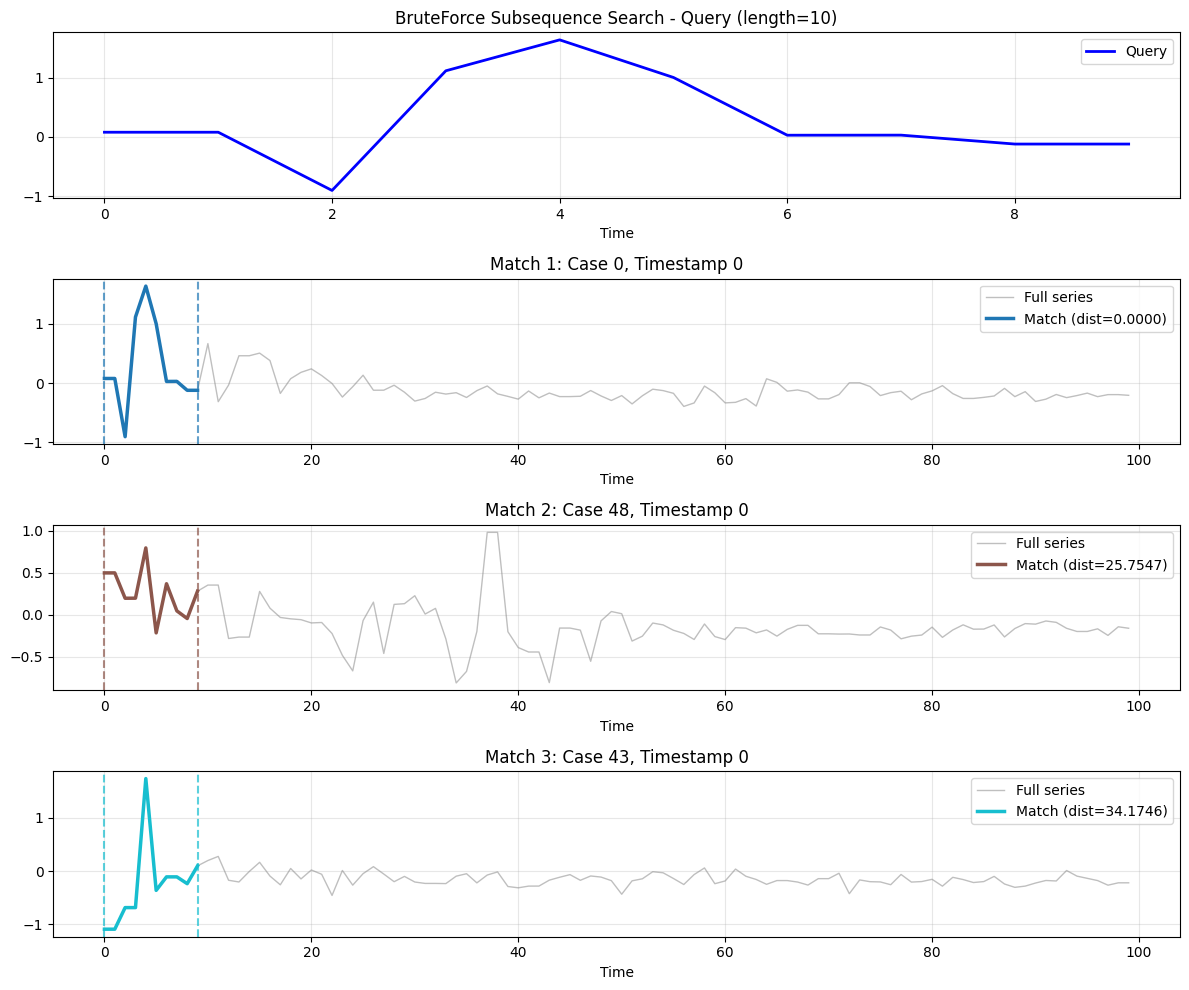

In [ ]:
# Visualize BruteForce subsequence search results
plot_subsequence_search_results(
    X, q, matches, distances, title="BruteForce Subsequence Search"
)


### 2.2 MASS (FFT-based)

`MASS` is an efficient FFT-based algorithm for finding similar subsequences.

In [5]:
# MASS is an FFT-based algorithm for fast subsequence search
# length=10 matches the query length
mass = MASS(length=10, normalize=False)
mass.fit(X)  # Fit on 3D collection

# Predict with k=3 to find top 3 closest subsequences
# Returns (indices, distances) where indices has shape (n_matches, 2)
# with (case_idx, timestamp)
matches, distances = mass.predict(q, k=3)
print("MASS matches shape:", matches.shape)
print("Matches (case_idx, timestamp):")
print(matches)
print("\nDistances:")
print(distances)

MASS matches shape: (3, 2)
Matches (case_idx, timestamp):
[[ 0  0]
 [48  0]
 [43  0]]

Distances:
[4.26325641e-14 2.57547117e+01 3.41746292e+01]


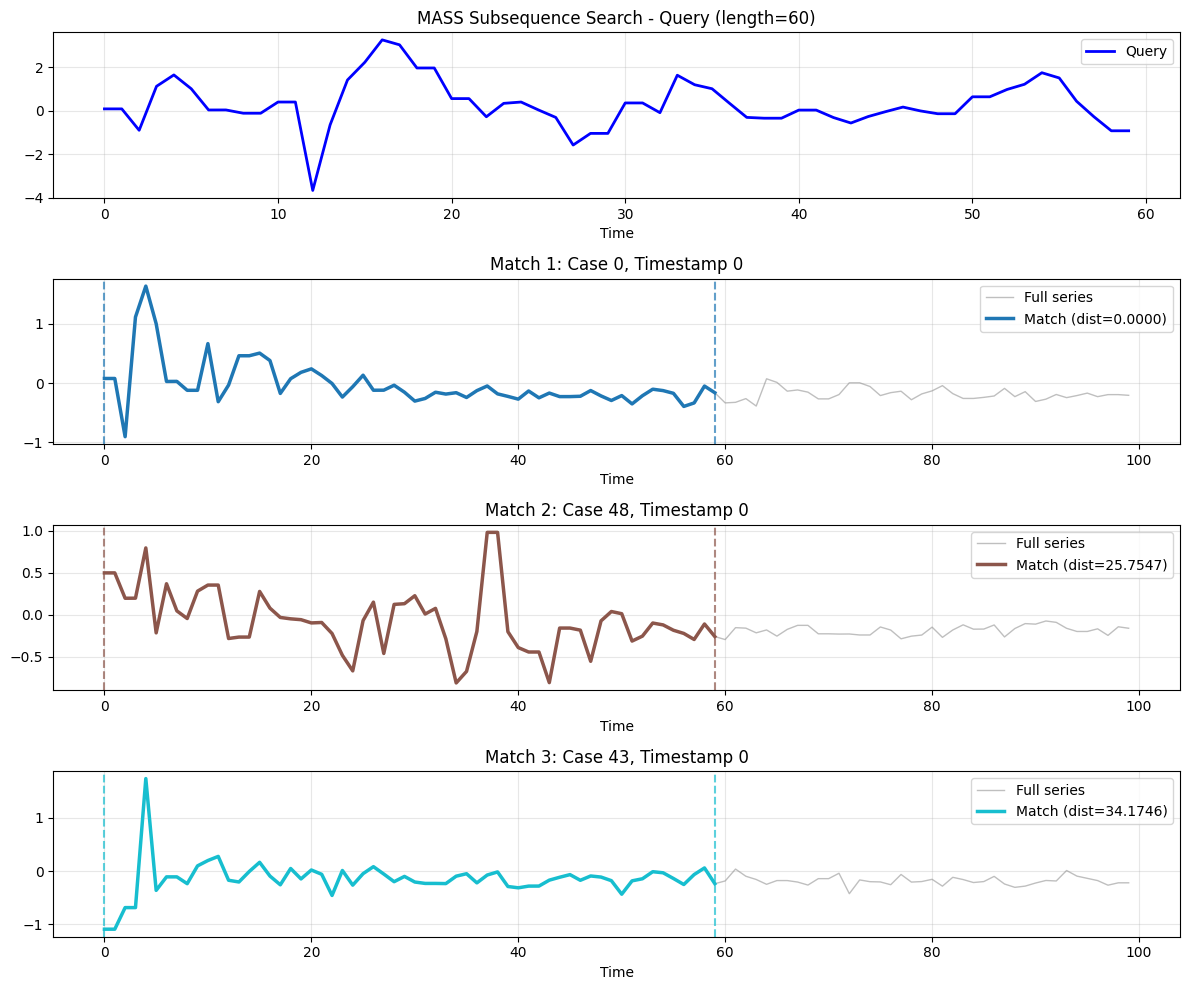

In [ ]:
# Visualize MASS subsequence search results
plot_subsequence_search_results(
    X, q, matches, distances, title="MASS Subsequence Search"
)

## 3. Whole Series Search

Whole series search estimators find the most similar complete time series within a collection. Unlike subsequence search, the query must have the same length as the series in the collection. The `predict` method returns a 1D array of shape `(n_matches,)` containing the indices of the most similar cases.

### 3.1 BruteForce (Exact)

`BruteForce` computes exact nearest neighbors using a specified distance function.

In [7]:
# Whole series search - query must be same length as fitted series
# Create a new collection with same-length series
X_whole, _ = make_example_3d_numpy(n_cases=10, n_channels=1, n_timepoints=50)
print("Collection shape:", X_whole.shape)

# Query is a single 2D series (same length as collection series)
q_whole = X_whole[3]  # Use one series from collection as query
print("Query shape:", q_whole.shape)

# Fit and predict with BruteForce whole series search
bf_whole = WholeBruteForce()
bf_whole.fit(X_whole)
matches_whole, distances_whole = bf_whole.predict(q_whole, k=3)
print("\nWhole series matches (case indices):", matches_whole)
print("Distances:", distances_whole)

Collection shape: (10, 1, 50)
Query shape: (1, 50)

Whole series matches (case indices): [3 0 5]
Distances: [  0.         115.64240958 115.84769948]


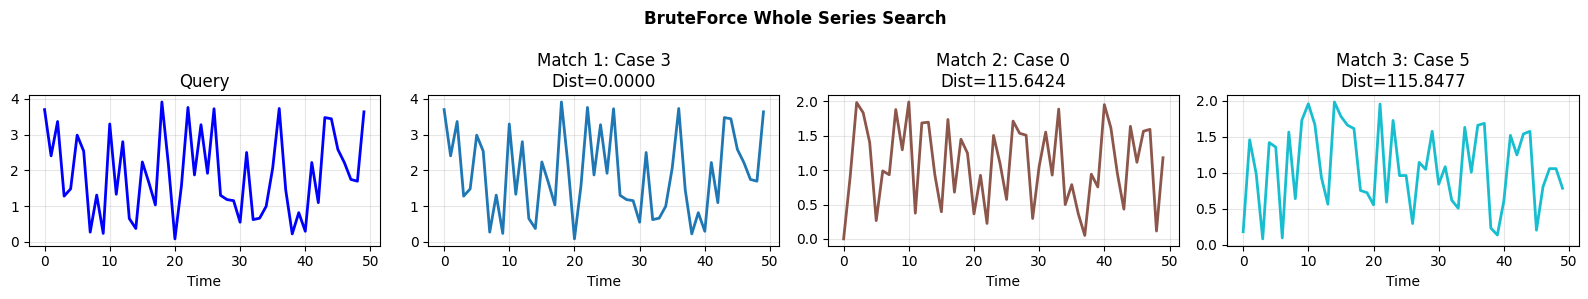

In [8]:
# Visualize whole series BruteForce search results
plot_whole_series_search_results(
    X_whole,
    q_whole,
    matches_whole,
    distances_whole,
    title="BruteForce Whole Series Search",
)

### 3.2 LSHIndex (Approximate)

`LSHIndex` uses locality-sensitive hashing for fast approximate nearest neighbor search. This is useful when the dataset is large and exact search is too slow.

In [9]:
from aeon.similarity_search.whole_series import LSHIndex

lsh = LSHIndex(n_hash_funcs=256, hash_func_coverage=0.25)
lsh.fit(X_whole)
matches_lsh, distances_lsh = lsh.predict(q_whole, k=3)
print("LSH approximate matches (case indices):", matches_lsh)
print("Distances (Hamming):", distances_lsh)

LSH approximate matches (case indices): [3 9 4]
Distances (Hamming): [  0. 106. 108.]


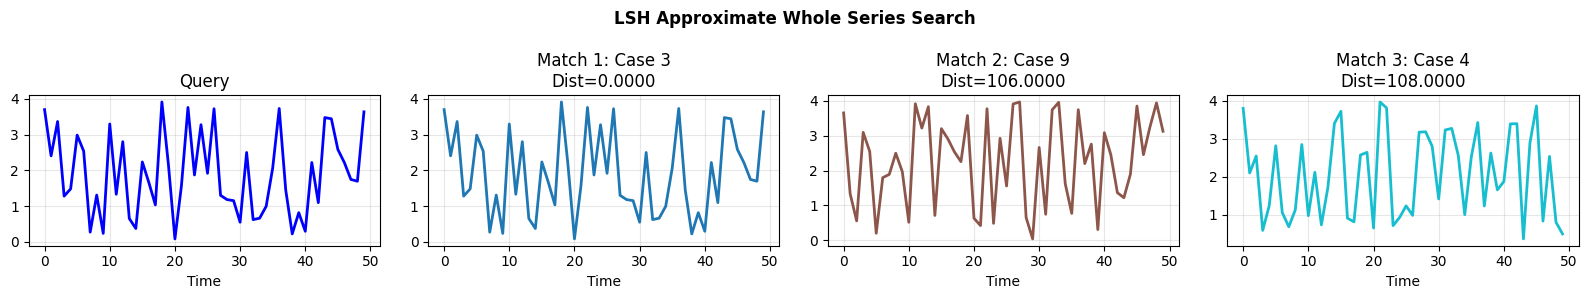

In [10]:
# Visualize LSH approximate search results
plot_whole_series_search_results(
    X_whole,
    q_whole,
    matches_lsh,
    distances_lsh,
    title="LSH Approximate Whole Series Search",
)